In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16 import VGG16
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#prevents overfitting and handles the imbalance in dataset

# normalizing the images
data_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

trainpath = '/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/train'
testpath = '/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/test'

# creating train data
train = data_aug.flow_from_directory(trainpath, target_size=(150, 150), class_mode='categorical', batch_size=36, shuffle=True )

# creating test data
test = data_aug.flow_from_directory(testpath, target_size=(150, 150), class_mode='categorical', batch_size=36, shuffle=True)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

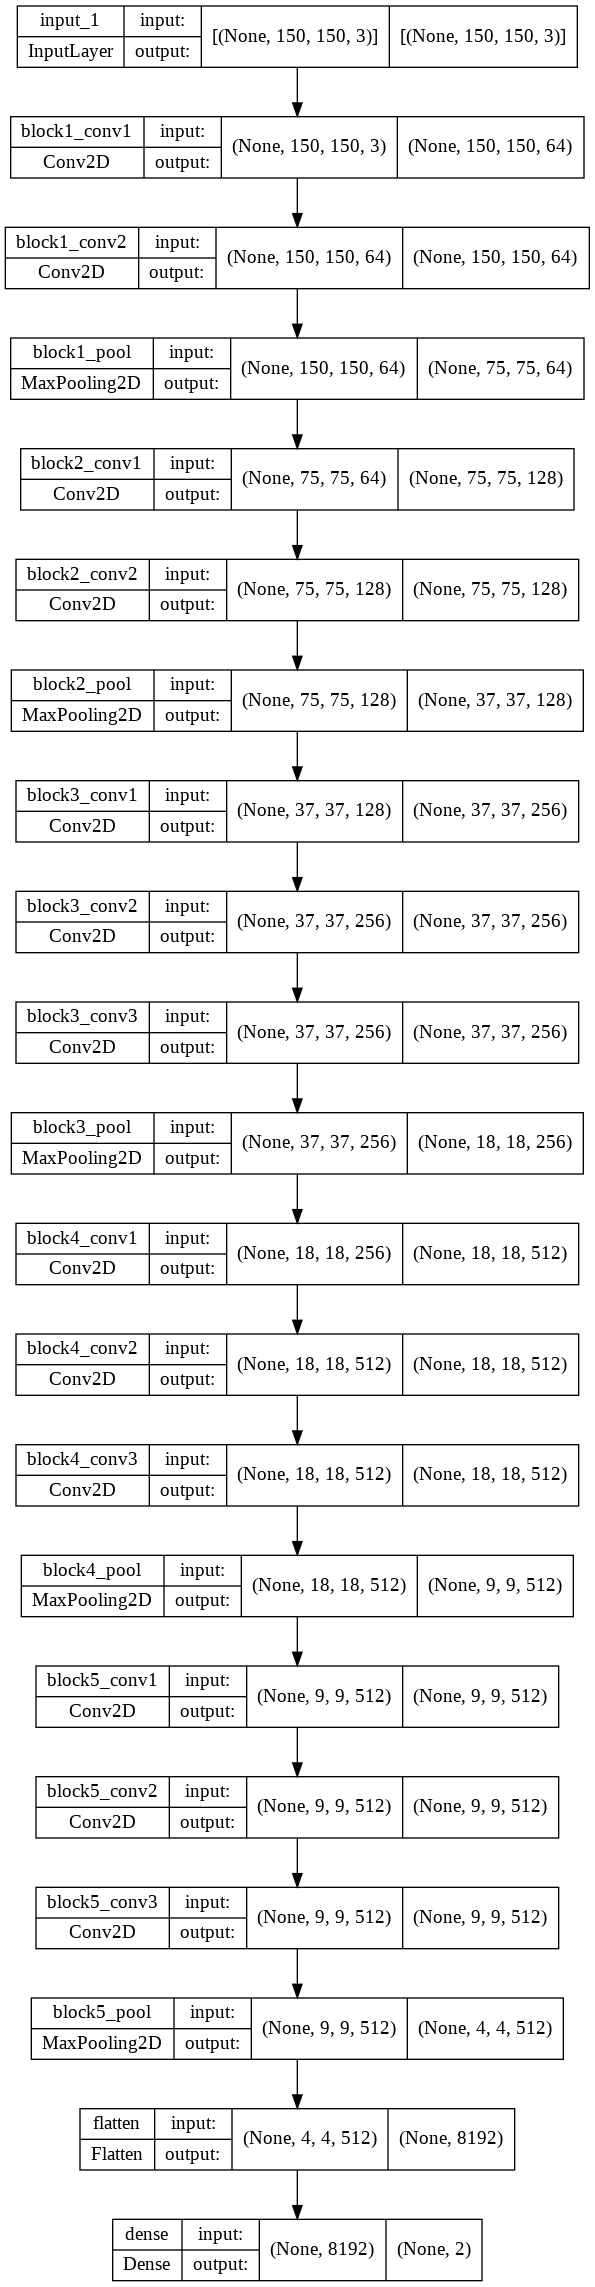

In [4]:
#building the model
IMAGE_SIZE =[150,150]

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# freezing restNet layers
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)

output_layer = Dense(2, activation='sigmoid')(x)

# creating early stopping.
es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
# creating model checkpoint
mc = ModelCheckpoint("VggModel.h5", monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# creating class weights
cw = {0: 1.0, 1: 1.0}

model = Model(inputs=vgg.input, outputs=output_layer)

model.summary()

plot_model(model, to_file = 'modelVgg_plot.png', show_shapes = True, show_layer_names = True)

In [5]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# fitting the model
history = model.fit(train, epochs=12, validation_data=test, callbacks = [es,mc],verbose=1,class_weight=cw)

Epoch 1/12
145/145 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.9442
Epoch 1: val_loss improved from inf to 2.17007, saving model to VggModel.h5
145/145 [==============================] - 765s 5s/step - loss: 0.7738 - accuracy: 0.9442 - val_loss: 2.1701 - val_accuracy: 0.8478
Epoch 2/12
145/145 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9778
Epoch 2: val_loss improved from 2.17007 to 1.74754, saving model to VggModel.h5
145/145 [==============================] - 68s 467ms/step - loss: 0.1673 - accuracy: 0.9778 - val_loss: 1.7475 - val_accuracy: 0.8750
Epoch 3/12
145/145 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9866
Epoch 3: val_loss did not improve from 1.74754
145/145 [==============================] - 67s 463ms/step - loss: 0.0994 - accuracy: 0.9866 - val_loss: 4.2770 - val_accuracy: 0.7885
Epoch 4/12
145/145 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9921
Epoch 4: val_

In [7]:
model.save('PNmodelVgg.h5')

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
print(X_test)
predictions = (model.predict(X_test) > 0.1).astype("int32")
print(predictions)
predictions = predictions.reshape(1, -1)[0]
predictions[:15]